<h1 STYLE="padding-left:1em;text-align: center;">Projet 08 : Participez à une competition Kaggle </h1>

# Introduction

<p STYLE="padding-left:1em;text-align:justify;"> Ce notebook présente le premier modèle soumis sur la plateforme Kaggle dans le cadre de la compétition UW-Madison GI Tract Image Segmentation : Track healthy organs in medical scans to improve cancer treatment <br><br>
Il porte sur la segmentation des intestins et de l'estomac sur les clichés d'IRMs afin d'éviter ses organes lors du traitement de la tumeur par radiothérapie.  

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

* Part 1: [Train --> uwmgtis Keras train_01](https://www.kaggle.com/code/benoitdacosta/uwmgtis-keras-train-01) 
* Part 2: [Inference --> uwmgtis Keras infer_01](https://www.kaggle.com/code/benoitdacosta/uwmgtis-keras-infer-01)

# Sommaire
<a href="#1" STYLE="padding-left:1em;color:black"><b>Etape 1 : Importation des librairies et configuration </b></a><br>
<a href="#2" STYLE="padding-left:1em;color:black"><b>Etape 2 : Preprocessing </b></a><br>
<a href="#3" STYLE="padding-left:1em;color:black"><b>Etape 3 : Fonctions</b></a><br>
<a href="#4" STYLE="padding-left:1em;color:black"><b>Etape 4 : DATASET</b></a><br>
<a href="#5" STYLE="padding-left:1em;color:black"><b>Etape 5 : FOLDS</b></a><br>
<a href="#6" STYLE="padding-left:1em;color:black"><b>Etape 6 : Metrics</b></a><br>
<a href="#7" STYLE="padding-left:1em;color:black"><b>Etape 7 : U-NET Models</b></a><br>
<a href="#7" STYLE="padding-left:1em;color:black"><b>Etape 8 : Prediction</b></a><br>

# <a STYLE="color:black" id="1">Etape 1 : Importation des librairies et configuration

In [2]:
import warnings
warnings.filterwarnings("ignore")

from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from pathlib import Path
import os 
from glob import glob
from joblib import parallel_backend, Parallel, delayed , dump , load
from tqdm import tqdm
from tqdm import tqdm
from tqdm.notebook import tqdm

from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

import tensorflow as tf
from tensorflow import keras
from keras import backend as K

from keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose,\
                         Concatenate, Input , Dropout, Lambda
from keras.models import Model , load_model

# from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from matplotlib.patches import Rectangle
import cv2

pd.set_option('display.max_columns',200)
pd.set_option('display.max_colwidth', 200)

In [3]:
# repertory ='/kaggle/input/'
# DIR = repertory + 'uw-madison-gi-tract-image-segmentation/' 


path_colab = os.path.abspath('')+'/drive/MyDrive/Colab Notebooks/P08'
sep = '/'if os.path.isdir(path_colab) else '\\'
repertory = path_colab if os.path.isdir(path_colab) else os.path.abspath('')
DIR = repertory+f'{sep}uw-madison-gi-tract-image-segmentation{sep}' 

TRAIN_DIR = DIR + 'train'
TEST_DIR = DIR + 'test'
train_csv = DIR +'train.csv' 
sample_sub = DIR + 'sample_submission.csv'

df_train = pd.read_csv(train_csv)
df_train.head(10)

,id,class,segmentation
0,case123_day20_slice_0001,large_bowel,NaN
1,case123_day20_slice_0001,small_bowel,NaN
2,case123_day20_slice_0001,stomach,NaN
3,case123_day20_slice_0002,large_bowel,NaN
4,case123_day20_slice_0002,small_bowel,NaN
5,case123_day20_slice_0002,stomach,NaN
6,case123_day20_slice_0003,large_bowel,NaN
7,case123_day20_slice_0003,small_bowel,NaN
8,case123_day20_slice_0003,stomach,NaN
9,case123_day20_slice_0004,large_bowel,NaN


In [4]:
class CFG:
    BATCH_SIZE    = 64
    img_size      = (128, 128, 3)
    n_fold        = 5
    fold_selected = 1
    epochs        = 100
    seed          = 42
    steps_per_epoch_train = None
    steps_per_epoch_val = None

# <a STYLE="color:black" id="2"> Etape 2 : Preprocessing

In [5]:
# Metadata
def preprocessing(df):
    #--------------------------------------------------------------------------
    df["case"] = df["id"].apply(lambda x: int(x.split("_")[0].replace("case", "")))
    df["day"] = df["id"].apply(lambda x: int(x.split("_")[1].replace("day", "")))
    df["slice"] = df["id"].apply(lambda x: x.split("_")[3])
    #--------------------------------------------------------------------------
    all_images = glob(os.path.join(TRAIN_DIR, "**", "*.png"), recursive=True)
    x = all_images[0].rsplit(sep , 4)[0] ## ../uw-madison-gi-tract-image-segmentation/train

    path_partial_list = []
    for i in range(0, df.shape[0]):
        path_partial_list.append(os.path.join(x,
                              "case"+str(df["case"].values[i]),
                              "case"+str(df["case"].values[i])+"_"+ "day"+str(df["day"].values[i]),
                              "scans",
                              "slice_"+str(df["slice"].values[i])))
    df["path_partial"] = path_partial_list
    #--------------------------------------------------------------------------
    path_partial_list = []
    for i in range(0, len(all_images)):
        path_partial_list.append(str(all_images[i].rsplit("_",4)[0]))

    tmp_df = pd.DataFrame()
    tmp_df['path_partial'] = path_partial_list
    tmp_df['path'] = all_images
    #--------------------------------------------------------------------------
    df = pd.merge(df,tmp_df, on="path_partial").drop(columns=["path_partial"])
    #--------------------------------------------------------------------------
    df["width"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[1]))
    df["height"] = df["path"].apply(lambda x: int(x[:-4].rsplit("_",4)[2]))
    df["px_spacing_h"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[3]))
    df["px_spacing_w"] = df["path"].apply(lambda x: float(x[:-4].rsplit("_",4)[4]))
    #--------------------------------------------------------------------------
    del x, path_partial_list, tmp_df
    #--------------------------------------------------------------------------
    
    return df 

In [6]:
train_df = preprocessing(df_train)
train_df.head()

,id,class,segmentation,case,day,slice,path,width,height,px_spacing_h,px_spacing_w
0,case123_day20_slice_0001,large_bowel,NaN,123,20,0001,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
1,case123_day20_slice_0001,small_bowel,NaN,123,20,0001,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
2,case123_day20_slice_0001,stomach,NaN,123,20,0001,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0001_266_266_1.50_1.50.png,266,266,1.5,1.5
3,case123_day20_slice_0002,large_bowel,NaN,123,20,0002,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5
4,case123_day20_slice_0002,small_bowel,NaN,123,20,0002,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case123\case123_day20\scans\slice_0002_266_266_1.50_1.50.png,266,266,1.5,1.5


# <a STYLE="color:black" id="3">Etape 3 : Fonctions

In [7]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = np.asarray(mask_rle.split(), dtype=int)
    starts = s[0::2] - 1
    lengths = s[1::2]
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)  # Needed to align to RLE direction

# ref.: https://www.kaggle.com/stainsby/fast-tested-rle
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [8]:
def id2mask(id_):
    itrain_df = train_df[train_df['id']==id_]
    wh = itrain_df[['height','width']].iloc[0]
    shape = (wh.height, wh.width, 3)
    mask = np.zeros(shape, dtype=np.uint8)
    for i, class_ in enumerate(['large_bowel', 'small_bowel', 'stomach']):
        ctrain_df = itrain_df[itrain_df['class']==class_]
        rle = ctrain_df.segmentation.squeeze()
        if len(ctrain_df) and not pd.isna(rle):
            mask[..., i] = rle_decode(rle, shape[:2])
    return mask

def rgb2gray(mask):
    pad_mask = np.pad(mask, pad_width=[(0,0),(0,0),(1,0)])
    gray_mask = pad_mask.argmax(-1)
    return gray_mask

def gray2rgb(mask):
    rgb_mask = tf.keras.utils.to_categorical(mask, num_classes=4)
    return rgb_mask[..., 1:].astype(mask.dtype)

In [9]:
def load_img(path):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img = img.astype('float32') # original is uint16
    img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
    img = img.astype('uint8')
    return img

def show_img(img, mask=None):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
#     plt.figure(figsize=(10,10))
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')

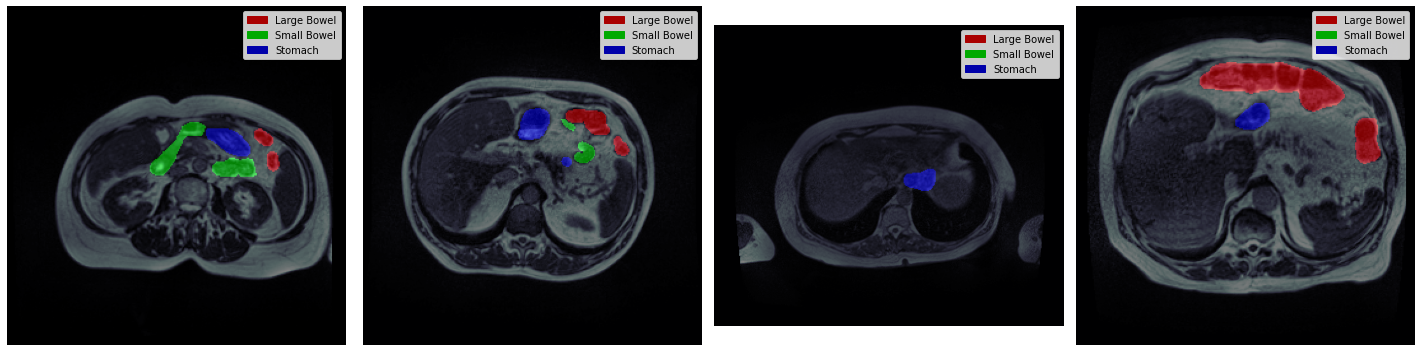

In [10]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(train_df[train_df.segmentation.notna()].sample(frac=1.0)['id'].unique()[:row*col]):
    img = load_img(train_df[train_df['id']==id_].path.iloc[0])
    mask = id2mask(id_)*255
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

In [11]:
# Restructure
def restructure(df, subset="train"):
    # RESTRUCTURE  DATAFRAME
    df_out = pd.DataFrame({'id': df['id'][::3]})

    if subset=="train":
        df_out['large_bowel'] = df['segmentation'][::3].values
        df_out['small_bowel'] = df['segmentation'][1::3].values
        df_out['stomach'] = df['segmentation'][2::3].values

    df_out['path'] = df['path'][::3].values
    df_out['case'] = df['case'][::3].values
    df_out['day'] = df['day'][::3].values
    df_out['slice'] = df['slice'][::3].values
    df_out['width'] = df['width'][::3].values
    df_out['height'] = df['height'][::3].values

    df_out=df_out.reset_index(drop=True)
    df_out=df_out.fillna('')
    if subset=="train":
        df_out['count'] = np.sum(df_out.iloc[:,1:4]!='',axis=1).values
        
    display(df_out.sample(5))
    return df_out

In [12]:
DF_train= restructure(train_df, subset="train")

,id,large_bowel,small_bowel,stomach,path,case,day,slice,width,height,count
36842,case2_day1_slice_0075,22001 6 22265 9 22530 11 22796 12 23062 12 23328 12 23594 13 23860 13 24126 13 24392 13 24658 13 24925 11 25191 10 25458 8 25724 8 25991 7 26258 6 26524 5 26791 3 30270 4 30535 7 30800 10 31066 11...,,17712 3 17971 13 18234 21 18499 23 18765 24 19031 25 19296 26 19562 27 19828 28 20094 28 20359 29 20625 30 20891 30 21157 30 21423 29 21688 30 21954 29 22219 29 22484 30 22750 28 23016 26 23282 24...,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case2\case2_day1\scans\slice_0075_266_266_1.50_1.50.png,2,1,0075,266,266,2
8930,case122_day25_slice_0067,14790 5 15054 14 15319 17 15583 19 15848 23 16114 24 16379 26 16645 30 16911 32 17177 34 17443 35 17709 36 17975 37 18241 37 18508 37 18775 36 19042 35 19309 33 19579 29 19846 27 20113 24 20381 3 ...,30410 1 30423 1 30674 5 30684 6 30939 8 30948 8 31204 17 31470 16 31736 13 32003 10 32270 8 32536 6 32804 2,16605 8 16870 11 17135 19 17400 25 17665 29 17930 32 18196 34 18461 36 18726 38 18990 42 19254 46 19517 50 19782 54 20046 57 20312 59 20577 61 20843 63 21109 64 21375 66 21641 67 21907 68 22173 70...,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case122\case122_day25\scans\slice_0067_266_266_1.50_1.50.png,122,25,0067,266,266,3
11679,case113_day22_slice_0048,43800 6 44158 9 44517 11 44877 12 45237 12 45597 12 45957 12 46317 11 46677 11 47038 8 47400 3,,46654 7 47012 10 47371 12 47730 14 48090 16 48449 18 48808 19 49168 20 49528 21 49887 22 50246 24 50605 25 50964 27 51323 28 51682 29 52041 31 52400 32 52759 33 53117 35 53475 37 53834 38 54193 39...,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case113\case113_day22\scans\slice_0048_360_310_1.50_1.50.png,113,22,0048,360,310,2
1735,case129_day0_slice_0008,,,,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case129\case129_day0\scans\slice_0008_360_310_1.50_1.50.png,129,0,0008,360,310,0
2974,case130_day22_slice_0095,29440 6 29705 10 29971 14 30237 17 30503 20 30769 22 31035 25 31301 26 31491 16 31568 25 31755 20 31834 25 32019 23 32101 24 32284 25 32369 22 32549 27 32637 21 32814 28 32905 19 33080 29 33172 18...,32667 7 32932 9 33198 10 33463 11 33729 11 33937 5 33994 13 34200 9 34259 27 34457 18 34525 28 34721 17 34790 30 34986 16 35056 30 35251 13 35322 31 35515 12 35588 31 35779 11 35854 32 36044 11 36...,,C:\Users\bud64\Desktop\Formation OCR\uw-madison-gi-tract-image-segmentation\train\case130\case130_day22\scans\slice_0095_266_266_1.50_1.50.png,130,22,0095,266,266,2


# <a STYLE="color:black" id="4">Etape 4 : DATASET

In [13]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size = CFG.BATCH_SIZE, subset="train", shuffle=False , img_shape = CFG.img_size):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.img_shape = img_shape
        self.indexes = np.arange(len(df))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        X = np.empty((self.batch_size,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        y = np.empty((self.batch_size,self.img_shape[0],self.img_shape[1],self.img_shape[2]))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        id_, heights, widths, classes = [] , [] ,[], [] 
        
        for i, img_path in enumerate(self.df['path'].iloc[indexes]):
            if self.subset != 'train':
                id_.append(self.df['id'].iloc[indexes[i]])
                heights.append(self.df['height'].iloc[indexes[i]])
                widths.append(self.df['width'].iloc[indexes[i]])
                classes.append(self.df['class'].iloc[indexes[i]])
            
            w=self.df['width'].iloc[indexes[i]]
            h=self.df['height'].iloc[indexes[i]]
            
            img = self.__load_grayscale(img_path)  
            X[i,] = img   
            
            if self.subset == 'train':
                for k,j in enumerate(["large_bowel","small_bowel","stomach"]):
                    rles = self.df[j].iloc[indexes[i]]
                    mask = rle_decode(rles, shape=(h, w, 1))
                    mask = cv2.resize(mask, self.img_shape[0:2] )
                    y[i,:,:,k] = mask
                    
        if self.subset == 'train':
            return X, y
        else: 
            return X , id_ , widths , heights , classes

    def __load_grayscale(self, img_path):
        img = cv2.imread(img_path, cv2.IMREAD_ANYDEPTH)
#         img = cv2.imread(img_path,cv2.IMREAD_UNCHANGED)
        dsize = self.img_shape[0:2]
        img = cv2.resize(img, dsize)
#         img = img.astype(np.int8) / 255.
        img = img.astype('float32') # original is uint16
        img = (img - img.min())/(img.max() - img.min())*255.0 # scale image to [0, 255]
        img = img.astype('uint8')/255
        img = np.expand_dims(img, axis=-1)
        return img

In [14]:
Train_masks = list(DF_train[DF_train['large_bowel']!=''].index)
Train_masks += list(DF_train[DF_train['small_bowel']!=''].index)
Train_masks += list(DF_train[DF_train['stomach']!=''].index)

DF_training = DF_train[DF_train.index.isin(Train_masks)]
DF_training.reset_index(inplace=True, drop = True)
print(DF_training.shape)

(16590, 11)


# <a STYLE="color:black" id="5">Etape 5 : FOLDS

In [15]:
skf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)

for fold, (_, val_idx) in enumerate(skf.split(X=DF_training, y=DF_training['count'],groups =DF_training['case']), 1):
    DF_training.loc[val_idx, 'fold'] = fold
    
# DF_training['fold'] = DF_training['fold'].astype(np.uint8)

train_idx = DF_training[DF_training["fold"]!=CFG.fold_selected].index
valid_idx = DF_training[DF_training["fold"]==CFG.fold_selected].index

# CFG.steps_per_epoch_train = len(train_idx) // CFG.BATCH_SIZE 
# if len(train_idx) % CFG.BATCH_SIZE !=0: 
#     CFG.steps_per_epoch_train +=1
    
# CFG.steps_per_epoch_val = len(valid_idx) //CFG.BATCH_SIZE
# if len(valid_idx) //CFG.BATCH_SIZE !=0: 
#     CFG.steps_per_epoch_val +=1

train_generator = DataGenerator(DF_training[DF_training.index.isin(train_idx)],batch_size = CFG.BATCH_SIZE , shuffle=True)
val_generator = DataGenerator(DF_training[DF_training.index.isin(valid_idx)], batch_size = CFG.BATCH_SIZE)

display(DF_training.groupby('fold').size())
display(DF_training.groupby(['fold','count'])['id'].count())

fold
1.0    3973
2.0    2806
3.0    3656
4.0    3121
5.0    3034
dtype: int64

fold  count
1.0   1         556
      2        2664
      3         753
2.0   1         362
      2        1843
      3         601
3.0   1         607
      2        2348
      3         701
4.0   1         566
      2        2018
      3         537
5.0   1         377
      2        2048
      3         609
Name: id, dtype: int64

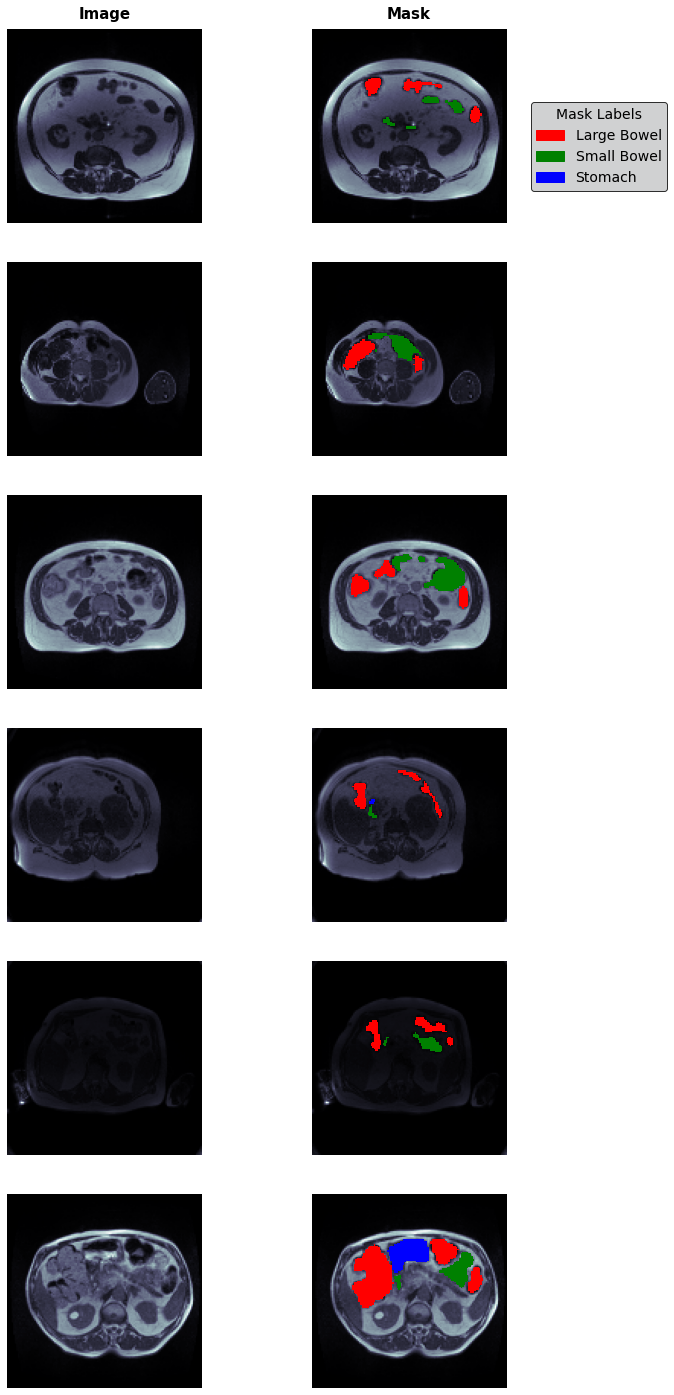

In [16]:
# Visualizing
fig = plt.figure(figsize=(10, 25))
gs = gridspec.GridSpec(nrows=6, ncols=2)
colors = ['red','green','blue']
labels = ["Large Bowel", "Small Bowel", "Stomach"]
patches = [ mpatches.Patch(color=colors[i], label=f"{labels[i]}") for i in range(len(labels))]

cmap1 = mpl.colors.ListedColormap(colors[0])
cmap2 = mpl.colors.ListedColormap(colors[1])
cmap3 = mpl.colors.ListedColormap(colors[2])

for i in range(6):
    images, mask = train_generator[i]
    sample_img=images[0,:,:,0]
    mask1=mask[0,:,:,0]
    mask2=mask[0,:,:,1]
    mask3=mask[0,:,:,2]
    
    ax0 = fig.add_subplot(gs[i, 0])
    im = ax0.imshow(sample_img, cmap='bone')

    ax1 = fig.add_subplot(gs[i, 1])
    if i==0:
        ax0.set_title("Image", fontsize=15, weight='bold', y=1.02)
        ax1.set_title("Mask", fontsize=15, weight='bold', y=1.02)
        plt.legend(handles=patches, bbox_to_anchor=(1.1, 0.65), loc=2, borderaxespad=0.4,fontsize = 14,title='Mask Labels', title_fontsize=14, edgecolor="black",  facecolor='#c5c6c7')

    l0 = ax1.imshow(sample_img, cmap='bone')
    l1 = ax1.imshow(np.ma.masked_where(mask1== False,  mask1),cmap=cmap1, alpha=1)
    l2 = ax1.imshow(np.ma.masked_where(mask2== False,  mask2),cmap=cmap2, alpha=1)
    l3 = ax1.imshow(np.ma.masked_where(mask3== False,  mask3),cmap=cmap3, alpha=1)
    _ = [ax.set_axis_off() for ax in [ax0,ax1]]

    colors = [im.cmap(im.norm(1)) for im in [l1,l2, l3]]

# <a STYLE="color:black" id="6">Etape 6 : Metrics

In [17]:
#Metrics
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(tf.cast(y_true, tf.float32), y_pred) + 0.5 * dice_loss(tf.cast(y_true, tf.float32), y_pred)


# <a STYLE="color:black" id="7">Etape 7 : U-NET Models

In [18]:
def conv_block(input, num_filters, batchnorm ):
    x = Conv2D(num_filters, kernel_size = (3,3), padding="same",)(input)
    if batchnorm : 
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, kernel_size = (3,3), padding="same")(x)
    if batchnorm : 
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters, dropout = False ,  batchnorm =True):
    x = conv_block(input, num_filters , batchnorm)
    p = MaxPool2D((2, 2))(x)
    if dropout : 
        p = Dropout(0.3)(p)
    return x, p

def decoder_block(input, skip_features, num_filters, dropout = False, batchnorm = True):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    if dropout : 
        x = Dropout(0.3)(x)
    x = conv_block(x, num_filters, batchnorm)
    return x

def build_unet(input_shape, dropout = False , batchnorm = True , activation = 'sigmoid'):

    inputs = Input(shape=input_shape)
    
    s1, p1 = encoder_block(inputs, 64 , dropout , batchnorm )
    s2, p2 = encoder_block(p1, 128, dropout , batchnorm  )
    s3, p3 = encoder_block(p2, 256, dropout , batchnorm )
    s4, p4 = encoder_block(p3, 512, dropout , batchnorm )

    b1 = conv_block(p4, 1024, batchnorm  )

    d1 = decoder_block(b1, s4, 512, dropout , batchnorm )
    d2 = decoder_block(d1, s3, 256, dropout , batchnorm )
    d3 = decoder_block(d2, s2, 128, dropout , batchnorm )
    d4 = decoder_block(d3, s1, 64, dropout , batchnorm )

    outputs = Conv2D(3, 1, padding="same", activation =activation )(d4)

    model = Model(inputs, outputs, name="U-Net")

    model.compile(optimizer=tf.keras.optimizers.Adam(),loss=bce_dice_loss,
                  metrics=[iou_coef , dice_coef])
    return model

# PLOT TRAINING
def plot_train(model):
    losses = model if isinstance(model, pd.DataFrame) else pd.DataFrame(model.history.history) 
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.plot(losses['loss'].index,losses['loss'],label='Train_Loss')
    plt.plot(losses['val_loss'].index,losses['val_loss'],label='Val_loss')
    plt.title('LOSS'); plt.xlabel('Epoch'); plt.ylabel('loss');plt.legend();

    plt.subplot(1,3,2)
    plt.plot(losses['dice_coef'].index,losses['dice_coef'],label='Train_dice_coef')
    plt.plot(losses['val_dice_coef'].index,losses['val_dice_coef'],label='Val_dice_coef')
    plt.title('DICE'); plt.xlabel('Epoch'); plt.ylabel('dice_coef');plt.legend(); 

    plt.subplot(1,3,3)
    plt.plot(losses['iou_coef'].index,losses['iou_coef'],label='Train_iou_coef')
    plt.plot(losses['val_iou_coef'].index,losses['val_iou_coef'],label='Val_iou_coef')
    plt.title('IOU'); plt.xlabel('Epoch'); plt.ylabel('iou_coef');plt.legend();
    plt.show()

def fit_model(model ,  model_name , train_dataset , validation_dataset ):
    if os.path.isfile(models_path+str(model_name)+'.h5'): 
        model = load_model(models_path+str(model_name)+'.h5', custom_objects={'bce_dice_loss': bce_dice_loss ,'iou_coef':iou_coef ,'dice_coef':dice_coef  })
        results = load(results_path+'score_'+str(model_name)+'.joblib')
        # model.summary()
        plot_train(results)

    else :
        # model.summary()
        early_stop = EarlyStopping(monitor='val_loss', patience=5)
        model.fit(train_dataset, epochs=CFG.epochs, validation_data=validation_dataset, callbacks=[early_stop])
                 
        results = pd.DataFrame(model.history.history)
        plot_train(model)
        
        dump(results,results_path+'score_'+str(model_name)+'.joblib',compress = True)
        model.save(models_path+str(model_name)+'.h5') 
    
    return model , results

In [19]:
models_path = repertory+sep+'Models'+sep
results_path = repertory+sep+'Results'+sep

# Kaggle
# models_path = '/kaggle/working/'
# results_path = '/kaggle/working/'

In [20]:
input_shape = CFG.img_size
model = build_unet(input_shape, dropout = True , batchnorm = True) 

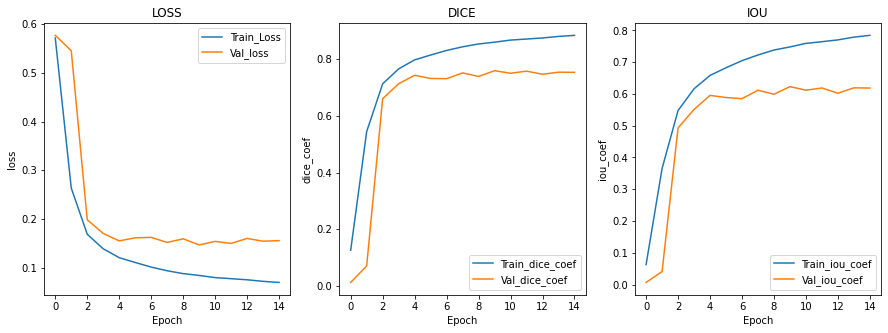

In [21]:
model , results = fit_model(model , 'U-net',train_generator , val_generator)

In [22]:
results

,loss,iou_coef,dice_coef,val_loss,val_iou_coef,val_dice_coef
0,0.571673,0.062827,0.126130,0.577204,0.006752,0.012731
1,0.263461,0.365242,0.544254,0.545685,0.041035,0.070814
2,0.168483,0.547744,0.712436,0.198193,0.492935,0.659924
3,0.138555,0.616000,0.765122,0.170131,0.551179,0.712748
4,0.120296,0.658151,0.796879,0.154851,0.595312,0.742552
5,0.110467,0.682246,0.813933,0.161093,0.588585,0.731503
6,0.100959,0.704597,0.830128,0.162066,0.585061,0.730700
7,0.093462,0.722443,0.842969,0.151610,0.611621,0.750952
8,0.087559,0.737989,0.852903,0.159057,0.598905,0.738481
9,0.083825,0.747769,0.859269,0.146499,0.622958,0.758903


# <a STYLE="color:black" id="8">Etape 8 : Prediction

In [23]:
sub_df = pd.read_csv(sample_sub)
if not len(sub_df):
    debug = True
    sub_df = pd.read_csv(train_csv)
    test_df = preprocessing(df_train,  subset = 'train')
    test_df = test_df[:1000*3]
else : 
    debug = False
    test_df = preprocessing(sub_df , subset = 'test')
    path_load_infer = repertory+'uwmgtis-keras-train-01/'

    models_path = path_load_infer 
    results_path = path_load_infer
    input_shape = CFG.img_size
    model = build_unet(input_shape, dropout = True , batchnorm = True)
    model , results = fit_model(model , 'U-net', None, None)
    
test_df.head(5)


KeyboardInterrupt



In [ ]:
def infer(DF , model , batch_size = CFG.BATCH_SIZE) : 
    pred_rle = []; pred_ids = []; pred_classes = [];
    
    DF_batch = DataGenerator(DF, batch_size =batch_size, subset="test", shuffle=False)
    for idx , (img , id_, widths , heights , classes) in enumerate(tqdm(DF_batch)):
#         msk = np.empty((batch_size,CFG.img_size[0],CFG.img_size[1],CFG.img_size[2]))
                                       
        preds = model.predict(img,verbose=0)
        
        # Rle encode 
        for j in range(batch_size):
            k = 0 if classes[j]=='large_bowel' else 1 if classes[j]=='small_bowel' else 2

            pred_img = cv2.resize(preds[j,:,:,k], ( widths[j] , heights[j]),
                                  interpolation=cv2.INTER_NEAREST) # resize probabilities to original shape
            pred_img = (pred_img>0.5).astype(dtype='uint8')    # classify

            pred_ids.append(id_[j])
            pred_classes.append(classes[j])
            pred_rle.append(rle_encode(pred_img))
    
    return pred_rle, pred_ids , pred_classes

In [ ]:
CFG.BATCH_SIZE = 3   
pred_rle, pred_ids , pred_classes = infer(test_df, model, batch_size = CFG.BATCH_SIZE)

In [ ]:
submission = pd.DataFrame({
    "id":pred_ids,
    "class":pred_classes,
    "predicted":pred_rle
})

if debug :
    sub_df = pd.read_csv(train_csv)
    del sub_df['segmentation']
else:
    sub_df = pd.read_csv(sample_sub)
    del sub_df['predicted']

sub_df = sub_df.merge(submission, on=['id','class'])
sub_df.to_csv('submission.csv',index=False)

submission.sample(10)